## Import the necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/language-detection/Language Detection.csv


In [2]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=afe609640fbe0a6920b5ff111aa5194def2a4e4d0a479721a3e07091d7eba083
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")


from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

## Updating the default configuration

In [4]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the dataset

In [5]:
df = pd.read_csv("/kaggle/input/language-detection/Language Detection.csv")
df = df.sample(frac=1)
df.head()

,Text,Language
7642,va bene iniziamo.,Italian
3104,"desculpe, eu não entendi isso.",Portugeese
7898,Yayımlanmış Vikipedi maddeleri ayrıca PediaPre...,Turkish
783,"is replaced with the question ""Can machines do...",English
1487,അങ്ങനെ അങ്ങനെ നിരന്തരമായ തിരുത്തലുകൾക്കൊടുവിൽ ...,Malayalam


## Feature Engineering

In [6]:
df.shape

(10337, 2)

In [7]:
df.Language.unique()

array(['Italian', 'Portugeese', 'Turkish', 'English', 'Malayalam',
       'Greek', 'German', 'Sweedish', 'Spanish', 'Dutch', 'French',
       'Russian', 'Danish', 'Kannada', 'Tamil', 'Arabic', 'Hindi'],
      dtype=object)

In [8]:
df.Language.replace(to_replace=['Portugeese','Sweedish'],value=['Portuguese','Swedish'],inplace=True)

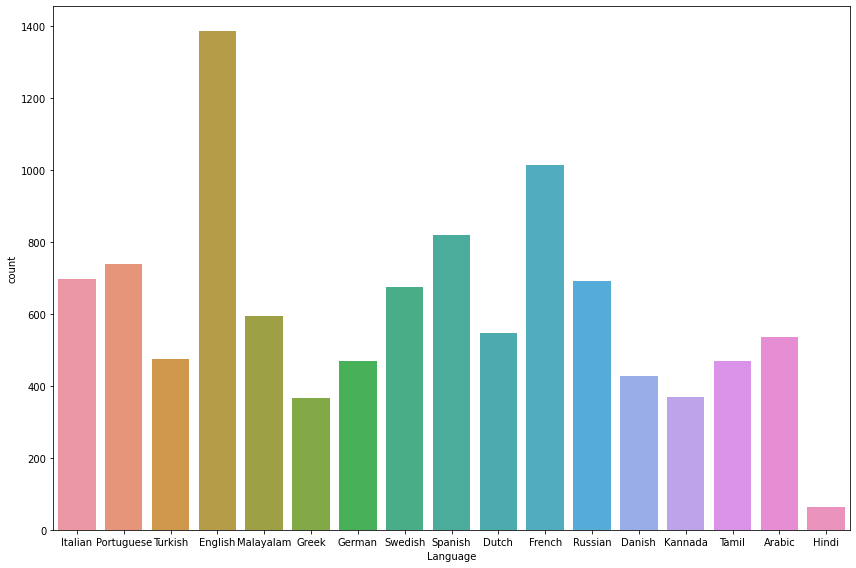

In [9]:
sns.countplot(df.Language)
plt.tight_layout();

In [10]:
df = df[df.Language.isin(["English","French","Dutch","Spanish","Danish","Italian","Swedish","German","Portuguese","Turkish"])]
df.shape

(7249, 2)

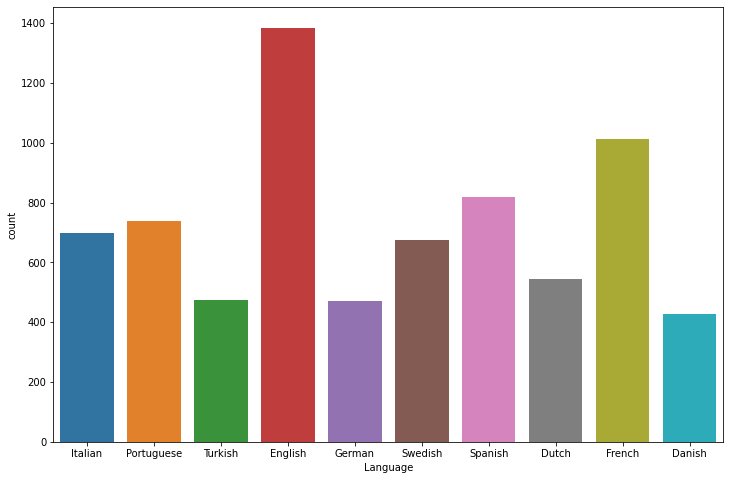

In [11]:
sns.countplot(df.Language);

The target language classes are considerably imbalanced so they need to be accounted for later.

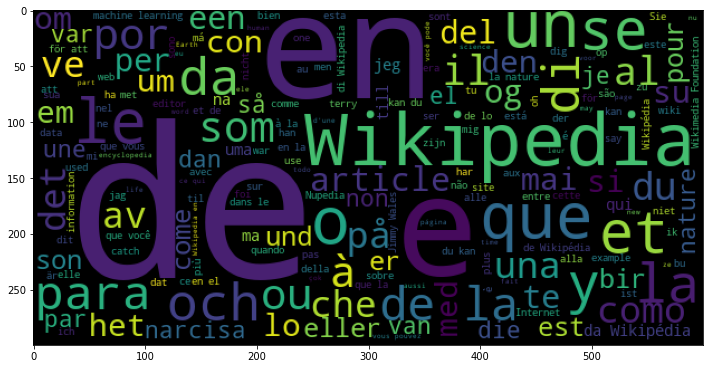

In [12]:
wc = WordCloud(width=600,height=300,random_state=42).generate(' '.join(df.Text))
plt.imshow(wc);

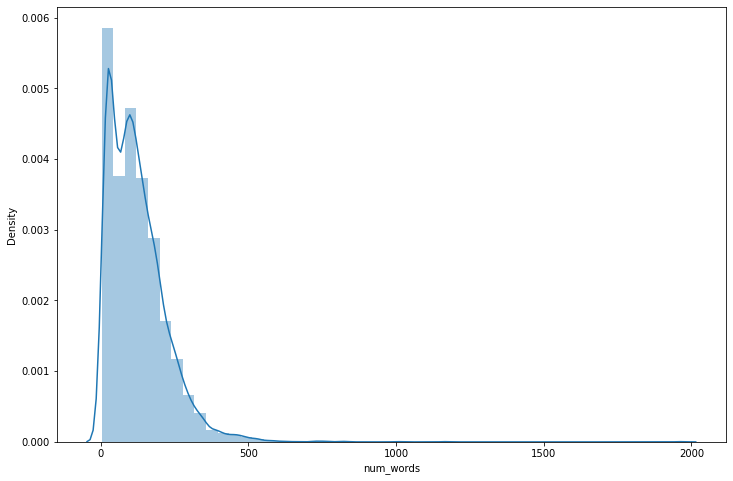

In [13]:
df['num_words'] = df.Text.apply(len)
sns.distplot(df.num_words);

In [14]:
df.num_words.describe()

count    7249.000000
mean      123.570010
std        98.117023
min         3.000000
25%        48.000000
50%       106.000000
75%       173.000000
max      1965.000000
Name: num_words, dtype: float64

In [15]:
max_len = 125

## Text Preprocessing

In [16]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [17]:
preprocessed_df = text_preprocess(df,'Text')
preprocessed_df.head()

,Text,Language,num_words
7642,va bene iniziamo,Italian,17
3104,desculpe eu no entendi isso,Portuguese,30
7898,yaymlanm vikipedi maddeleri ayrca pediapress p...,Turkish,107
783,replaced question can machines as thinking ent...,English,87
9642,ich habe nicht zugehrt weil du vielleicht besc...,German,62


## Encoding the target label classes

In [18]:
labels_dict = {}
for idx, lang in enumerate(preprocessed_df.Language.unique()):
    labels_dict[lang] = idx
labels_dict

{'Italian': 0,
 'Portuguese': 1,
 'Turkish': 2,
 'English': 3,
 'German': 4,
 'Swedish': 5,
 'Spanish': 6,
 'Dutch': 7,
 'French': 8,
 'Danish': 9}

In [19]:
preprocessed_df['Label'] = preprocessed_df.Language.map(labels_dict)
preprocessed_df.head()

,Text,Language,num_words,Label
7642,va bene iniziamo,Italian,17,0
3104,desculpe eu no entendi isso,Portuguese,30,1
7898,yaymlanm vikipedi maddeleri ayrca pediapress p...,Turkish,107,2
783,replaced question can machines as thinking ent...,English,87,3
9642,ich habe nicht zugehrt weil du vielleicht besc...,German,62,4


In [20]:
preprocessed_df.sample(frac=1)

,Text,Language,num_words,Label
4669,je hebt helemaal gelijk,Dutch,24,7
3417,globalement peut apprhender cette question en ...,French,129,8
3020,voc est meio de algo e algum est lhe pedindo p...,Portuguese,91,1
919,for example rule n n p e b u r g e r displayst...,English,324,3
343,obvious vandalism generally easy remove wikipe...,English,137,3
...,...,...,...,...
9581,unten im beschreibungsfeld dafr und jetzt ist ...,German,187,4
756,the latter started sanger attempt create relia...,English,93,3
8840,jag r rdd att jag inte hller med,Swedish,36,5
7433,nell ambito dell apprendimento automatico la t...,Italian,176,0


## Splitting the preprocessed dataset into train and test sets

In [21]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=42,shuffle=True,stratify=preprocessed_df.Language)

## Downloading the pretrained tokenizer and xlm-roberta-base language detection model

In [22]:
tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
xlm = TFAutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection",from_pt=True)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

2022-12-21 09:34:09.657171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 09:34:09.658144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 09:34:09.659159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 09:34:09.659950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 09:34:09.660718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


## Performing text tokenization

In [23]:
X_train = tokenizer(text=train_df.Text.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)

X_test = tokenizer(text=test_df.Text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

## Fine-tuning the pretrained xlm-roberta-base language detection model

In [24]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [25]:
embeddings = xlm(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=10,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

## Model Architecture

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 125)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 125)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_for_sequence_clas TFSequenceClassifier 278059028   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
flatten (Flatten)               (None, 20)           0           tfxlm_roberta_for_sequence_cl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


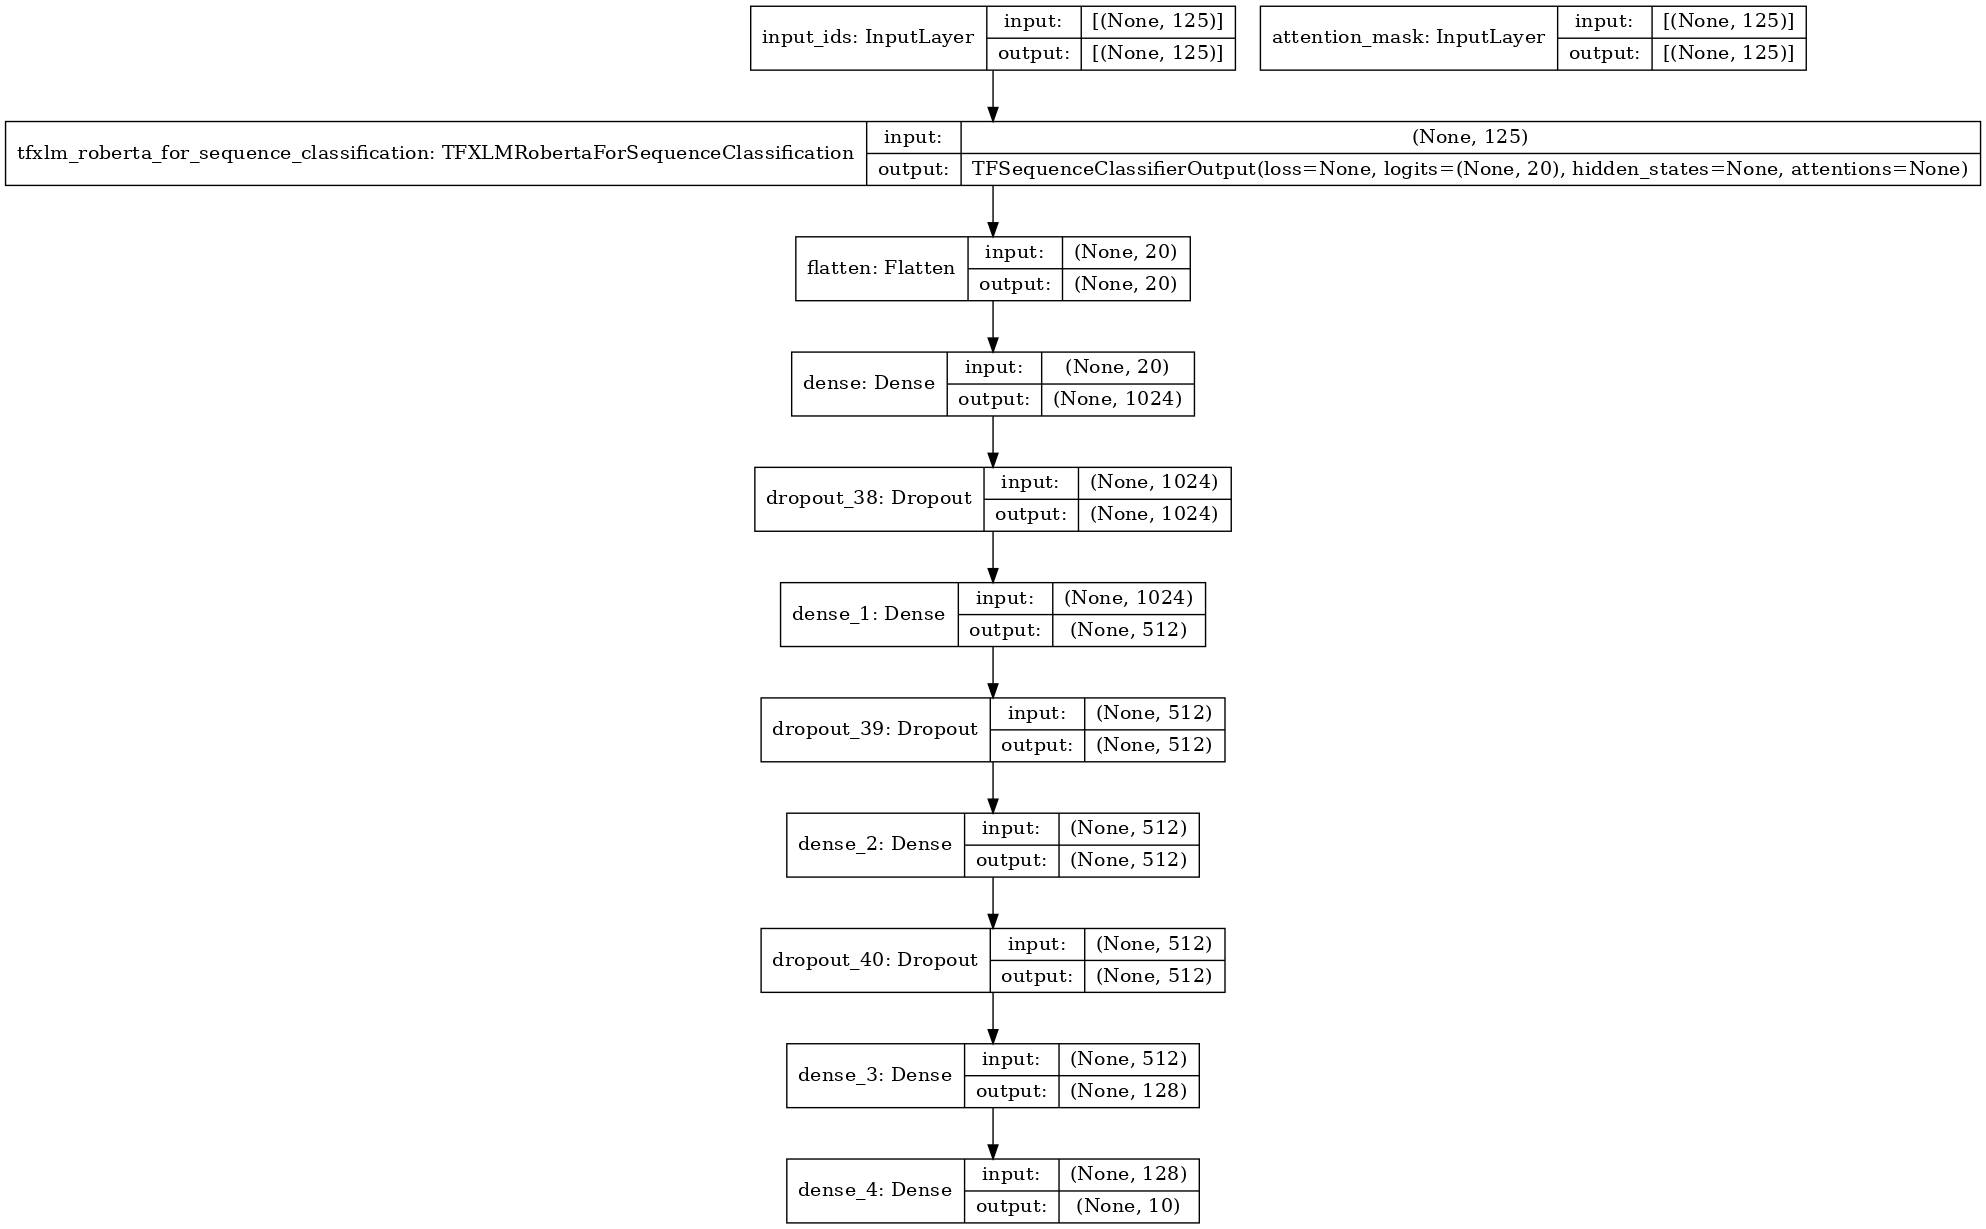

In [27]:
plot_model(model,'model.png',show_shapes=True,dpi=100,rankdir='TB')

## Compiling the model

In [28]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)
loss = CategoricalCrossentropy()
metrics = CategoricalAccuracy('balanced_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

## Training the fine-tuned XLM-Roberta-Base transformer model

In [29]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint(filepath='checkpoint',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=to_categorical(train_df.Label),
              epochs=50,
              batch_size=64,
              callbacks=[es,mc],
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
             )

2022-12-21 09:34:52.611420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
80/80 [==============================] - 163s 2s/step - loss: 1.3802 - balanced_accuracy: 0.6730 - val_loss: 0.5346 - val_balanced_accuracy: 0.8759


2022-12-21 09:37:36.178344: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
2022-12-21 09:37:37.490590: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.



Epoch 00001: val_balanced_accuracy improved from -inf to 0.87586, saving model to checkpoint


2022-12-21 09:37:52.311671: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-21 09:38:28.250443: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
2022-12-21 09:38:29.315618: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
2022-12-21 09:38:30.410041: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.


Epoch 2/50
80/80 [==============================] - 143s 2s/step - loss: 0.4218 - balanced_accuracy: 0.9013 - val_loss: 0.1863 - val_balanced_accuracy: 0.9752

Epoch 00002: val_balanced_accuracy improved from 0.87586 to 0.97517, saving model to checkpoint
Epoch 3/50
80/80 [==============================] - 143s 2s/step - loss: 0.1536 - balanced_accuracy: 0.9765 - val_loss: 0.1177 - val_balanced_accuracy: 0.9770

Epoch 00003: val_balanced_accuracy improved from 0.97517 to 0.97701, saving model to checkpoint
Epoch 4/50
80/80 [==============================] - 143s 2s/step - loss: 0.0825 - balanced_accuracy: 0.9858 - val_loss: 0.1207 - val_balanced_accuracy: 0.9761

Epoch 00004: val_balanced_accuracy did not improve from 0.97701
Epoch 5/50
80/80 [==============================] - 143s 2s/step - loss: 0.0728 - balanced_accuracy: 0.9858 - val_loss: 0.1210 - val_balanced_accuracy: 0.9775

Epoch 00005: val_balanced_accuracy improved from 0.97701 to 0.97747, saving model to checkpoint
Epoch 6/

## Analyzing the overall performance of trained model

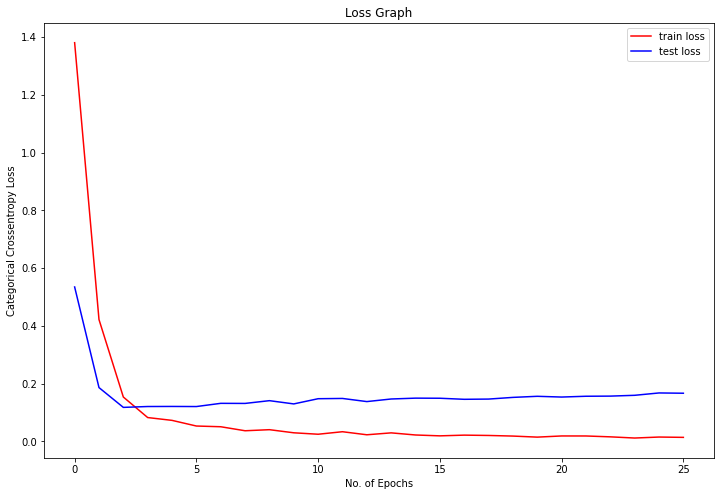

In [30]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

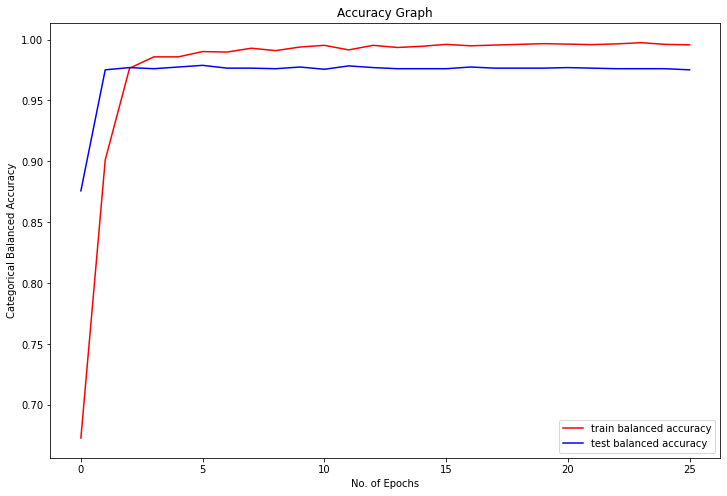

In [31]:
plt.plot(r.history['balanced_accuracy'],'r',label='train balanced accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test balanced accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Balanced Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [32]:
model.save('language_detector.h5')

## Model Evaluation

In [33]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
print("Categorical Cross-entropy Loss:", loss)
print("Categorical Accuracy:", acc)

68/68 [==============================] - 18s 261ms/step - loss: 0.1206 - balanced_accuracy: 0.9789
Categorical Cross-entropy Loss: 0.12063389271497726
Categorical Accuracy: 0.9788506031036377


In [37]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.Label,test_predictions))
print('-----------------------------')
print("Encoded Labels:")
print(labels_dict)
print('-----------------------------')
print("Classification Report:")
print(classification_report(test_df.Label,test_predictions))

Confusion Matrix:
[[205   2   0   0   0   0   2   0   0   0]
 [  0 220   0   2   0   0   0   0   0   0]
 [  0   0 140   0   1   0   0   1   0   0]
 [  2   0   0 412   1   0   1   0   0   0]
 [  0   0   1   0 137   0   0   0   1   2]
 [  0   0   0   1   0 201   0   0   0   1]
 [  1   6   0   0   0   0 237   0   2   0]
 [  0   0   1   2   1   0   1 158   0   1]
 [  2   1   1   0   0   0   2   0 297   1]
 [  0   0   0   0   0   5   0   0   1 122]]
-----------------------------
Encoded Labels:
{'Italian': 0, 'Portuguese': 1, 'Turkish': 2, 'English': 3, 'German': 4, 'Swedish': 5, 'Spanish': 6, 'Dutch': 7, 'French': 8, 'Danish': 9}
-----------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       209
           1       0.96      0.99      0.98       222
           2       0.98      0.99      0.98       142
           3       0.99      0.99      0.99       416
           4       0.98      0.97      0.9

The results are quite outstanding as the fine-tuned xlm-roberta-base transformer model has produced an amazing f1-score of more than 95% for all the languages.

If you adore my work, please don't forget to upvote it! 